In [ ]:
#| default_exp utils

In [ ]:
#| export
import os
import subprocess
import numpy as np
from dezero2.core import Variable
#from dezero2.utils import get_dot_graph

from IPython.display import display
from graphviz import Source

In [ ]:
#| export
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'

    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)

In [ ]:
# Test _dot_var()
x = Variable(np.random.randn(2,3))
x.name = 'x'
print(_dot_var(x), end='')
print(_dot_var(x, verbose=True), end='')

126147020906976 [label="x", color=orange, style=filled]
126147020906976 [label="x: (2, 3) float64", color=orange, style=filled]


digraph {
126147020906976 [label="x: (2, 3) float64", color=orange, style=filled]
}


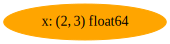

In [ ]:
# display graphcally
txt = "digraph {\n" + _dot_var(x, verbose=True) + "}"
print(txt)
display(Source(txt))

In [ ]:
#| export
def _dot_func(f):
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)

    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y())) # y is weakref
    return txt

126146536044928 [label="Add", color=lightblue, style=filled, shape=box]
126146543050128 -> 126146536044928
126146536034512 -> 126146536044928
126146536044928 -> 126146536043920



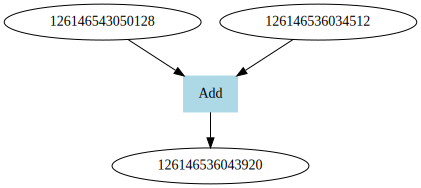

In [ ]:
# test _dot_func()
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)
display(Source("digraph {\n" + txt + "}"))

In [ ]:
#| export
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f):
        if f in seen_set:
            return
        funcs.append(f)
        seen_set.add(f)
        #funcs.sort(key=lambda x: x.generation)

    add_func(output.creator)
    txt += _dot_var(output, verbose)

    while funcs:
        f = funcs.pop()
        txt += _dot_func(f)
        for x in f.inputs:
            txt += _dot_var(x, verbose)

            if x.creator is not None:
                add_func(x.creator)
    return 'digraph g {\n' + txt + '}'

In [ ]:
#| export
def __plot_dot_graph(output, verbose=True): display(Source(get_dot_graph(output, verbose)))

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)
    display(Source(dot_graph))

    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)

    extension = os.path.splitext(to_file)[1][1:]  # Extension(e.g. png, pdf)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)

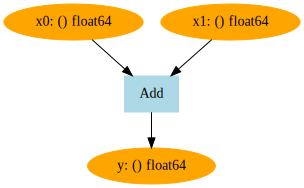

In [ ]:
# test get_dot_graph
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

plot_dot_graph(y)

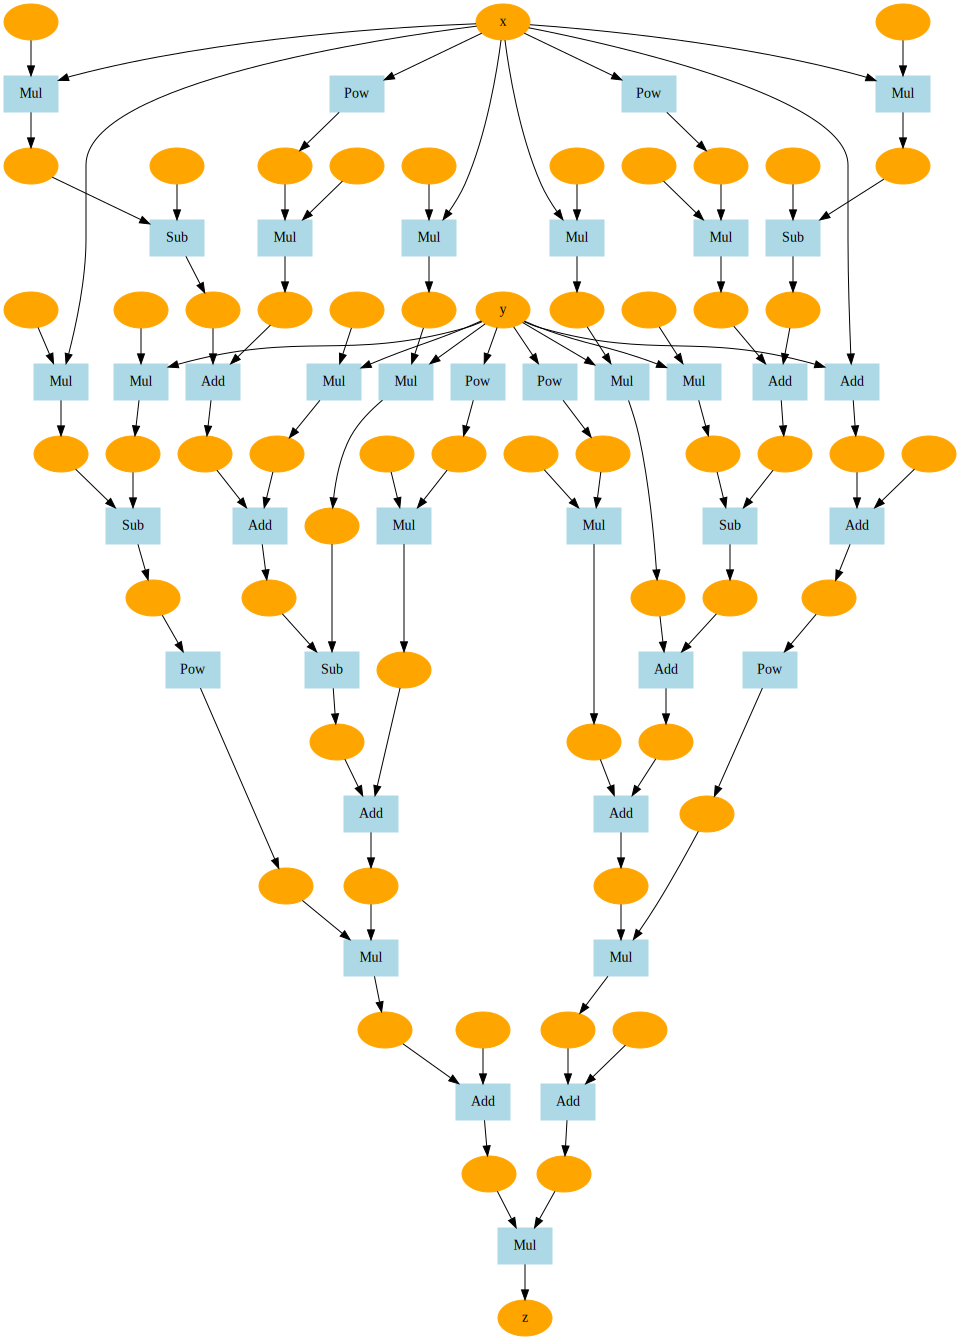

In [ ]:
# test plot_dot_graph
from dezero2.utils import plot_dot_graph
def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()
x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()